In [79]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization

from  keras.layers  import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.utils.image_utils import img_to_array,load_img


In [12]:
# load file
def load_file(dir):
    file=open(dir,'r')
    text=file.read()
    file.close()
    return text.splitlines()
dir='./data/'
# load captions
img_caption=load_file(dir+'captions.txt')

In [13]:
# load descriptions {id:[caption1,caption2,caption3 ....]}
def load_descriptions(img_captions):
    decription=dict()
    for data in img_captions[1:]:
        key,caption=data.split(',',maxsplit=1)
        key=key[:-4]
        if key in decription.keys():
            decription[key]+=[caption]
        else : decription[key]=[caption]
    return decription
descriptions=load_descriptions(img_caption)

In [14]:
# standard caption
def clean_descriptions(descriptions):
    table=str.maketrans('','',string.punctuation)
    for key,decrs in descriptions.items():
        for i,decr in enumerate(decrs):
            decr=decr.lower()
            decr=decr.translate(table)
            decr=decr.strip()
            decr=" ".join([w for w in decr.split(' ') if w.isalpha()])
            decr=" ".join([w for w in decr.split(' ') if len(w)>1])
            decrs[i]=decr
clean_descriptions(descriptions)

In [ ]:
descriptions

In [15]:
# save description with format id_img + caption
# '1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way',
def save_descriptions(descriptions,filename):
    lines=list()
    for key,descs in  descriptions.items():
        for desc in descs:
            lines.append(key + " "+ desc)
    data='\n'.join(lines)    
    file=open(filename,'w')
    file.write(data)
    file.close()
save_descriptions(descriptions,'descriptions.txt')


In [16]:
# get id img
id_img=[id for id in descriptions.keys()]
train_id,test_id,val_id=id_img[:6000],id_img[6000:7000],id_img[7000:]


In [18]:
def load_clean_descriptions(filename, dataset):
    file=open(filename,'r')
    text=file.read()
    file.close()
    descriptions = dict()
    for line in text.split('\n'):
        tokens = line.split(' ',maxsplit=1)
        image_id, image_desc = tokens[0], tokens[1]
        if image_id in dataset:
            if image_id not in descriptions.keys():
                descriptions[image_id]=list()
            desc='startseq ' +image_desc+' endseq'
            descriptions[image_id].append(desc)
    return descriptions
train_descs=load_clean_descriptions('descriptions.txt',train_id)

In [ ]:
train_descs

In [20]:
def load_pic(path):
    img=load_img(path,target_size=(299,299))
    img=img_to_array(img)
    img=np.expand_dims(img,0)
    img=keras.applications.inception_v3.preprocess_input(img)
    return img

In [44]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 15s 0us/step


In [45]:
model_new=Model(model.input,model.layers[-2].output)

In [46]:
def encode(img):
    img=load_pic(img)
    fea_vec=model_new.predict(img)
    fea_vec=np.reshape(fea_vec,fea_vec.shape[1])
    return fea_vec


In [47]:
def entire_encode(train_img):
    encoding={}
    for img in train_img:
        encoding[img]=encode("./Data/Images/"+img+".jpg")
    return encoding

In [70]:
encode_train=entire_encode(train_id)

2023-02-01 11:02:13.111801: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [48]:
encode_test=entire_encode(test_id)

1/1 [==============================] - 0s 156ms/step


In [50]:
def save_encode(path,encoding_train):
    with open(path, "wb") as encoded_pickle:
        dump(encoding_train, encoded_pickle)

In [51]:
save_encode("encode_train_img.pkl",encode_train)
save_encode("encode_test_img.pkl",encode_test)

In [22]:
train_features = load(open("encode_train_img.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [23]:
# get all train captions 
all_train_captions = []
for key, descs in train_descs.items():
    for desc in descs:
        all_train_captions.append(desc)
len(all_train_captions)

30000

In [24]:
# take words that appear more than 10 times
words_count={}
nsents=0
for sent in all_train_captions:
    nsents+=1
    for w in sent.split(' '):
        words_count[w]=words_count.get(w,0)+1
vocab=[w for w in words_count if words_count[w]>=10]
print('preprocessed words %d -> %d' % (len(words_count), len(vocab)))

preprocessed words 7668 -> 1667


In [25]:
# convert letters to numbers
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # Add 1 for padding word
vocab_size

1668

In [26]:
# longest sentence in caption
def to_lines(dictionary):
    l=list()
    for key in dictionary.keys():
        [l.append(d) for d in dictionary[key] ]
    return l
def max_length(dictionary):
    lines=to_lines(dictionary)
    return max(len(d.split()) for d in lines)
max_length = max_length(train_descs)
max_length

34

In [28]:
def load_glove(path):
    f = open(path, encoding="utf-8")
    embeddings_index = {} # empty dictionary
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index
embeddings_index=load_glove('glove.6B.200d.txt')

In [29]:
len(embeddings_index)

400000

In [32]:
embedding_dim =200
embedding_matrix=np.zeros((vocab_size,embedding_dim))
for word,i in wordtoix.items():
    embeddings_vector=embeddings_index.get(word)
    if embeddings_vector is not None:
        embedding_matrix[i]=embeddings_vector

In [57]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [58]:
# model.summary()
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.optimizer.lr = 0.001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descs)//number_pics_per_bath

In [61]:
model.load_weights('weight.h5')

In [38]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key]
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [array(X1), array(X2)], array(y)
                X1, X2, y = list(), list(), list()
                n=0

In [98]:
for i in range(5):
    generator = data_generator(train_descs, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1000/1000 [==============================] - 108s 108ms/step - loss: 2.8015 - accuracy: 0.3526


In [63]:
# Với môi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi sau đó cho vào model để dự đoán từ tiếp theo. Ta thêm từ
# vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq' là kết thúc hoặc cho đến khi chuỗi dài 34 từ.
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
# encode_test

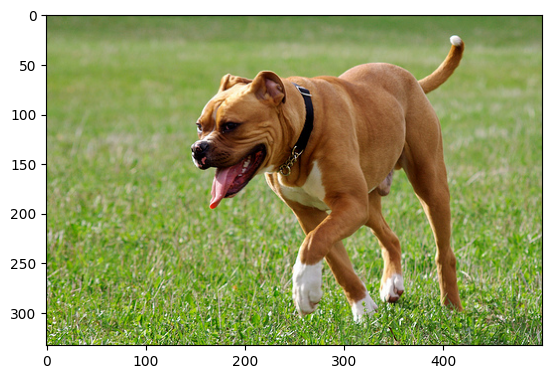

brown dog is running through the grass


In [107]:
z=17
pic = list(encode_test.keys())[z]
image = encode_test[pic].reshape((1,2048))
x=plt.imread('./Data/Images/'+pic+'.jpg')
plt.imshow(x)
plt.show()
print(greedySearch(image))


In [127]:
model.save('/kaggle/working/weight.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
